# How do I load a spectrum into Python from a text file? #

Use the `np.loadtxt()` command described [here](NumPy.html#How-do-I-load-tab-delimited-data-from-a-text-file-into-a-NumPy-array?). The next block gives an example using `np.loadtxt()` along with `np.interp()` to interpolate to a new frequency axis. 

# How do I interpolate spectroscopic data to a new frequency axis? # 

Interpolation is quite simple using the `np.interp()` function. The first argument should be your desired (new) frequency axis; the second is the original frequency axis; and the third is the y-values for each of the original data points. The code below gives an example of both loading data from a text file and interpolating to a new frequency axis. 

Two notes of caution: 
1. Make sure your interpolation endpoints are *inside* the limits of your original data. You can't interpolate between data points that you don't have!
2. Beware interpolating signals with very narrow features. If your spectrum contains a peak that has only one or two sample points, there's no realistic way for the interpolation algorithm to "guess" what the value should be in between those sample points. (Is it flat? Does it go up? Or down?) Interpolation is only reliable if your sample rate is high enough that each peak is sampled many times. 

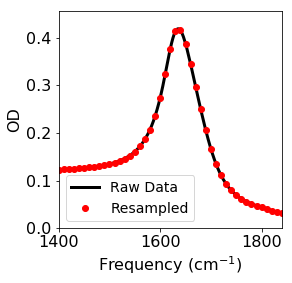

In [44]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

# This is a "convenience" function that 
#   1. loads data from a text file and then
#   2. interpolates to a user-supplied frequency axis. 
# If loading more than one spectrum, this is *very* helpful
# since you only have to code the np.loadtxt() part once and
# since all spectra then have the same frequency axis. 
def get_spec(fname, vaxis):
    dat = np.loadtxt(fname, delimiter=',')
    ydat = np.interp(vaxis, dat[:,0], dat[:,1])
    return ydat

# Start frequency
v1 = 1400.0

# Stop frequency
v2 = 1850.0

# Step size
vstep = 10.0

# Frequency axis
vaxis = np.arange(v1, v2, vstep)

# Raw data
h2oraw = np.loadtxt('H2O.dpt', delimiter=',')

# Interpolated data
h2oint = get_spec('H2O.dpt', vaxis)

plt.figure(figsize=(4,4))
# And compare the two
plt.plot(h2oraw[:,0], h2oraw[:,1], 'k', 
         linewidth=3, label='Raw Data')
plt.plot(vaxis, h2oint, 'or', label='Resampled')

plt.legend(fontsize=14)
plt.xlabel('Frequency (cm$^{-1}$)')
plt.xlim(vaxis[0], vaxis[-1])
plt.ylim(0, np.max(h2oint)*1.1)
plt.ylabel('OD')
plt.show()

# How do I baseline-correct a spectrum? #

A variety of instrumentation or sample preparation issues can give rise to broad, flat backgrounds in experimental measurements. To eliminate these artifacts, spectra are often "baseline-corrected" by subtracting a flat line from the experimental data to more accurately reflect the real signal from your sample. 


### Warnings ###

Before we discuss *how* to baseline-correct, a couple of comments are in order:

1. **Don't do it** if you don't have to! It's often possible to eliminate the need for baseline correction "at the source", i.e., by preparing your sample or collecting your data in a way that avoids the artifact in question. Is there particulate material in the sample that's causing scatter? It may be possible to remove this material by centrifugation or filtration. Are you getting an innacurate baseline because you haven't properly calibrated for the responsiveness of your detector? If so, calibrate! It's **always** preferable to eliminate the source of the baseline rather than to correct for it in post-processing, since postprocessing always introduces the possibility of bias -- even if it's not intentional. <br><br>

2. If you have to **document it**! When baseline issues can't be avoided experimentally, there's nothing wrong with performing a baseline correction. But you **must** document your processing -- make clear both that the data **has** been baseline-corrected and **how** the baseline-correction was performed. The explanation doesn't need to be complicated; often it's sufficient to add a statement like "A linear baseline was subtracted from raw absorption spectra to produce a flat baseline between 1400 cm$^{-1}$ and 1800 cm$^{-1}$". But it's absolutely critical (both scientifically and ethically) that such a statement be included in a place visible to the reader. (Don't hide it in the Supporting Information where the reader is unlikely to find it.) <br><br>

3. Always **use common sense** in your corrections. This is of course somewhat subjective, but be on your guard against biasing your data by cherry-picking the "best" baseline-correction points. Watch especially for unphysical features, such as negative regions in an absorption spectrum. Since baselines are almost never perfectly flat, it's not unusual to get broad negative features far from the region of interest. E.g., if you're interested in protein Amide I signals between 1600 and 1700 cm$^{-1}$, it's not necessarily a problem if your signal goes negative near 2800 cm$^{-1}$ since, e.g., sample scatter may be very different there than at 1700 cm$^{-1}$. It *is* likely a problem if you have a large negative feature at 1750 cm$^{-1}$, just outside the region of interest; this very likely means that you've over-subtracted your baseline and you should *not* trust your corrected spectrum. **Never** try to hide such features, e.g., by limiting the display range in a figure to carefully exclude them. This is both misleading and unethical. If you believe you understand the origin of an unusual figure, be up-front about it; include the feature in your published figures (along with your explanation) so that your readers can make up their own minds about it. <br><br>

### Procedure ###

With those warnings in place, let's talk about how to run baseline corrections. Whenever possible, the safest strategy is to 
* Pick two frequencies $\nu_1$ and $\nu_2$ where you know your absorption *should* be zero. The two frequencies should always be (a) as close as possible to the signal of interest and (b) as far as possible from each other. Ideally, these two points should be on opposite sides of your signal of interest (one to higher frequency and one to lower frequency), but this may not always be possible. E.g., for protein Amide I measurements (signal of interest between 1600 cm$^{-1}$ and 1700 cm$^{-1}$), a suitable choice might be $\nu_1$ = 1775 cm$^{-1}$ and $\nu_2$ = 1850 cm$^{-1}$, since very few materials absorb in this range. (Even better would be if $\nu_1$ could be below 1600 cm$^{-1}$, but this is usually not possible since other infrared absorption bands <br><br>

* Use the following equation to build a baseline ($S(\nu)$ represents your signal:
$$ B(\nu) = S(\nu_1) + \frac{S(\nu_2) - S(\nu_1)}{\nu_2 - \nu_1} \cdot (\nu - \nu_1) .$$
Here $\nu$ should be your frequency axis. (If your axis is in wavelength units instead of frequency, just choose wavelength values $\lambda_1$ and $\lambda_2$ instead of $\nu_1$ and $\nu_2$.) The first term here is just the value of the signal at $\nu_1$; when $B(\nu)$ is subtracted from your total signal, this will bring the corrected signal to zero at $\nu_1$. The second term doesn't change the value at $\nu_1$ (since $\nu - \nu_1 = 0$ when $\nu = \nu_1$) but adds a linearly increasing offset as the frequency moves away from $\nu_1$. In particular, when $\nu = \nu_2$ the second term will be equal to exactly $S(\nu_2) - S(\nu_1)$, so that $B(\nu_2) = S(\nu_2)$. Thus the baseline interpolates linearly between $S(\nu_1)$ and $S(\nu_2)$. <br><br>

* Subtract the baseline from your data. The corrected signal should be
$$S_\text{corr}(\nu) = S(\nu) - B(\nu).$$


### Example Code ###

The cell below gives sample code for baseline-correcting an absorption spectrum of a solution of live *Synechocystis PCC 6803* cells. The sample contains a great deal of scatter due to the fact that the size of the cells (on the order of a few $\mu$m) is similar to the wavelength of light passing through the sample (on the order of 500 nm = 0.5$\mu$m. 

Fortunately, we know that this system should *not* absorb line below roughly 750 nm, and the baseline is almost perfectly linear in this region. We thus choose $\lambda_1 = 750$ nm and $\lambda_2 = 850$ nm for baseline correction. Note the artifact (highlighted in gray in the figure below) due to very high OD near 300 nm. The signal rises rapidly as $\lambda$ decreases, before plunging below zero; this is classic indicator that too little light is getting through to the detector for accurate measurements in this region. The sample needs to be diluted if reliable short-wavelength data is needed. 

If this data were to be published, a statement along the following lines would be included: "A linear baseline was subtracted from the raw absorption spectrum to produce a flat baseline between 750 nm and 850 nm." Ideally, the raw spectrum would also be provided (both as text data and as a plotted image) so that readers can check for themselves whether they approve of the data handling. 

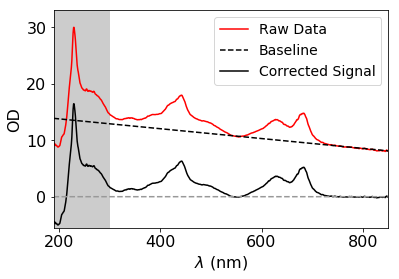

In [9]:
# Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

###################################################
# Data processing
###################################################
# Load and plot raw data 
dat = np.loadtxt('SynPCC6803cells.tsv')
laxis = dat[:,0]
S = dat[:,1]

# Choose reference points below 700 nm, 
# where real signal is minimal
lambda1 = 750.0
lambda2 = 850.0

# Find the corresponding indices:
n1 = np.argmin(np.abs(laxis-lambda1))
n2 = np.argmin(np.abs(laxis-lambda2))

# Build the baseline:
B = S[n1] + ((S[n2] - S[n1])/(lambda2 - lambda1))*(laxis-lambda1)

# Subtact from the signal
Scorr = S - B


###################################################
# Plotting
###################################################

# Plot the raw data
plt.plot(laxis, S, 'r', label='Raw Data')

# Plot the baseline
plt.plot(laxis, B, 'k--', label='Baseline')

# Plot baseline-corrected signal
plt.plot(laxis, Scorr, 'k', label='Corrected Signal')

# Add a second baseline for corrected signal
plt.plot(laxis, 0*laxis, '--', color=0.6*np.ones(3,))

# Add a gray patch to highlight high-OD artifact
plt.fill_between([laxis[0], 300], [1.1*np.max(S), 1.1*np.max(S)], 
                 [-np.max(S),-np.max(S)], color=0.8*np.ones((3,)))
plt.ylim(1.1*np.min(Scorr), 1.1*np.max(S))
plt.xlim(laxis[0], laxis[-1])

# Add a legend and format axes
plt.legend(fontsize=14)
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('OD')

plt.show()

# How do I smooth a spectrum? #

Spectroscopic noise can be both asthetically displeasing and visually distracting, often obscuring real spectroscopic signals. For this reason it's often tempting to "smooth" your data, by (in some form) applying a filter that eliminates high-frequency fluctuations. 

### Warnings ###

However, there are real dangers in careless or overly aggressive smoothing. On the one hand, smoothing might cause you to miss a real signal that's present in your data; conversely, it can make high-frequency noise look like real signal by "smearing" it out into broader features. And smoothing **alway** lowers the true resolution of your measurement, since it blurs the distinction between nearby spectroscopic features. 

But the greatest danger in smoothing is simply misrepresentation of your results. Smoothed data can easily give casual readers a false impression of the quality and reliability of experimental data. For this reason, any smoothing of raw data should be clearly and prominently documented in any publication, with a statement such as "Raw experimental data were smoothed by convolution with a Gaussian with a full-width at half maximum (FWHM) of 10 cm$^{-1}$." Don't hide it in the Supporting Information!

### Procedure ###

There are many approaches to smoothing data, but probably the simplest is to convolve your signal with an appropriate smoothing function. Since frequency-domain convolutions translate to products in the time domain, this is exactly equivalent to Fourier-filtering with a filter whose Fourier transform is your smoothing function. (If the smoothing function is Gaussian, the equivalent Fourier filter is also Gaussian.)

You can build a Gaussian filter in Python using the `np.exp()` function. If `vaxis` is your frequency axis: 

``Gauss = np.exp(-((vaxis-np.mean(vaxis))**2) / (2.0*sigma**2))``

will produce a vector `Gauss` that stores a Gaussian with standard deviation `sigma` and peaking in the middleof `vaxis`. Whatever smoothing shape you choose it **must** peak in the middle of the frequency axis; otherwise, convolution with the smoothing function will shift your signal away from the original frequency range. It's also helpful to normalize your smoothing function so that the sum is exactly 1; this guarantees that applying the smoothing function to your signal won't change the normalization of (i.e., area under) the signal. In Python, you can normalize the smoothing function via

``Gauss /= np.sum(Gauss)``

Note that, instead of giving the standard deviation $sigma$, spectroscopists often specify the width of spectral features via the "Full width at half maximum" or FWHM. If your smoothing function has a maximum value of 1, the FWHM is the difference in frequency (or wavelength) between the two points where the curve falls to a value of 0.5 (on the high-frequency and low-frequency sides, respectively). Gaussian curves have the form
$$ g(\nu) \propto \exp\left(-\frac{(\nu - \mu)^2}{2 \sigma^2} \right). $$
This curve takes its maximum value at $\nu = \mu$, and it falls to exactly half of this value when 
$$ \exp\left(-\frac{(\nu - \mu)^2}{2 \sigma^2} \right) = \frac{1}{2}$$
or (taking $\ln$ of both sides)
$$ -\frac{(\nu - \mu)^2}{2 \sigma^2} = - \ln 2. $$
Rearranging and taking the square root gives
$$ \nu = \mu \pm \sqrt{2 \sigma^2 \ln 2}.$$
The two solutions to this equation are the two frequencies where the curve takes on half its maximal value. Thus 
$$ FWHM = 2 \sqrt{2 \sigma^2 \ln 2} = 2 \sqrt{2 \ln 2} \sigma \approx 2.355 \sigma .$$
If you know the FWHM you want, you can specify the corresponding `sigma` value as 

``sigma = FWHM / (2.0*np.sqrt(2.0*np.log(2.0)))``

Finally, calculate your smoothed signal as 

``Ssmth = np.convolve(S, Gauss, 'same')``

The flag ``same`` ensures that the data returned by `np.convolve()` will peak in the same frequency range as your original data. (But see warning above: the smooth function **must** peak in the middle of the original frequency axis.)

The code below compares the baseline-corrected *Synechocystis* absorption spectra from the last example with spectra that have been smoothed with 5 nm, 10 nm, and 20 nm Gaussians. Note that the noise decreases as the smoothing width increases, but the shape of the spectrum also begins to change, reflecting the lower true resolution of the smoothed data. 

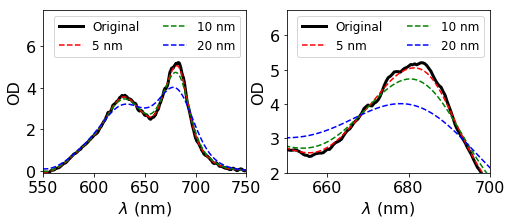

In [10]:
# Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

###################################################
# Baseline Correction
###################################################
# Load and plot raw data 
dat = np.loadtxt('SynPCC6803cells.tsv')
laxis = dat[:,0]
S = dat[:,1]

# Choose reference points below 700 nm, 
# where real signal is minimal
lambda1 = 750.0
lambda2 = 850.0

# Find the corresponding indices:
n1 = np.argmin(np.abs(laxis-lambda1))
n2 = np.argmin(np.abs(laxis-lambda2))

# Build the baseline:
B = S[n1] + ((S[n2] - S[n1])/(lambda2 - lambda1))*(laxis-lambda1)

# Subtact from the signal
Scorr = S - B


###################################################
# Smoothing
###################################################

# FWHM = 5.0
# First calculate the standard deviation
sig5 = 5.0 / 2.0*np.sqrt(2.0*np.log(2.0))

# Now build the Gaussian, centered at the mean of the frequency axis
Gauss5 = np.exp(-((laxis-np.mean(laxis))**2)/(2*sig5**2))

# Normalize it to preserve the area under the spectrum after convolution
Gauss5 /= np.sum(Gauss5)

# And apply the convolution. The 'same' flag will automatically 
# restrict the frequency range of the final convolved signal to 
# the same frequency range as the original signal Scorr. 
# It's important here that Gauss5 is centered in the *middle* of 
# the numeric frequency axis. Otherwise, the convolved signal would
# be shifted away from the true frequency axis. 
S5 = np.convolve(Scorr, Gauss5, 'same')

# And the same for FWHM = 10 and 20:
# FWHM = 10.0
sig10 = 10.0 / 2.0*np.sqrt(2.0*np.log(2.0))
Gauss10 = np.exp(-((laxis-np.mean(laxis))**2)/(2*sig10**2))
Gauss10 /= np.sum(Gauss10)
S10 = np.convolve(Scorr, Gauss10, 'same')

# FWHM = 20
sig20 = 20.0 / 2.0*np.sqrt(2.0*np.log(2.0))
Gauss20 = np.exp(-((laxis-np.mean(laxis))**2)/(2*sig20**2))
Gauss20 /= np.sum(Gauss20)
S20 = np.convolve(Scorr, Gauss20, 'same')


###################################################
# Plotting
###################################################

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
# Plot baseline-corrected signal
plt.plot(laxis, Scorr, 'k', label='Original', linewidth=3)
plt.plot(laxis, S5, 'r--', label='5 nm')
plt.plot(laxis, S10, 'g--', label='10 nm')
plt.plot(laxis, S20, 'b--', label='20 nm')

plt.xlim(550, 750)
plt.ylim(-0.1, 7.75)

# Add a legend and format axes
plt.legend(fontsize=12, ncol=2)
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('OD')

plt.subplot(1,2,2)
# Plot baseline-corrected signal
plt.plot(laxis, Scorr, 'k', label='Original', linewidth=3)
plt.plot(laxis, S5, 'r--', label='5 nm')
plt.plot(laxis, S10, 'g--', label='10 nm')
plt.plot(laxis, S20, 'b--', label='20 nm')

plt.xlim(650, 700)
plt.ylim(2, 6.75)

# Add a legend and format axes
plt.legend(fontsize=12, ncol=2)
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('OD')

plt.show()

# How do I use Python to fit a curve or spectrum? #

Use the `scipy.optimize.curve_fit()` function. Syntax here can be a little confusing: 

* The first argument provided to `optimize.curvefit()` must itself *be a function* -- in particular the function you want to use to fit the spectrum. Not the value of a function after it's evalutated, but the function itself! In the example below, the first argument passed to `optimize.curve_fit` is the function `multi_gauss` defined earlier. Note that the function is passed *without* parenthesis (i.e., as "`multi_gauss`" not as "`multi_gauss(...)`" since the latter would be the *value* of the function `multi_gauss` evaluated with some specific set of input parameters. <br><br>

* The second argument to `optimize.curvefit()` should be a vector containing the values of your independent variable (i.e., the x-axis) -- in this case a frequency (or wavelength) axis. <br><br>

* The third argument should be the set of y-values you want to fit -- in this case your spectrum. <br><br>

* The fourth argument should be your "initial guess" as to the set of parameters that will appropriately fit the spectrum. Here we've done this very crudely by just checking where the spectrum peaks and how broad it is, but it often happens that you need to set these input parameters manually (and more intelligently than this).  <br><br>

* The optional `bounds=()` argument is used to set upper and lower bounds on the parameters. In this case, we set a single lower bound (`0`) and a single upper bound (`np.inft`) for all parameters. But individual upper and lower bounds can also be specified for *each* parameter. 


There's also some subtlety involved in defining the `multi_gauss()` function used to reproduce the spectrum. The first line of our function definition reads: <br><br>
``def multi_gauss(xvals, *params):``<br><br>
Note the asterisk in front of `params`: this is necessary because we want `multi_gauss` to accept a variable number of arguments, which will be accessed as `params[0]`, `params[1]`, etc. (This is something like, but not quite the same as, passing a pointer to an array in C programming.) This is necessary because ``optimize.curvefit`` expects that the fit functions arguments will come in sequential order, with the independent variable (the frequency axis) first and then, in order, all remaining arguments. Since we want to use the same fit function (`multi_gauss`) to fit curves using 2 Gaussians or 3 Gaussians or 4 Gaussians, etc., we need it to accept a variable number of arguments (3 arguments for each Gaussian). This same syntax is needed when we calculate the final fitted curve (the line "``fspec = multi_gauss(laxis, *fpars)``" below.)

Comp 0:
    Amp:	2.35590434413
    mu:		642.598216208
    sigma:	38.2806154473

Comp 1:
    Amp:	3.76153974026
    mu:		681.878679322
    sigma:	10.6585399231

Comp 2:
    Amp:	1.30662808779
    mu:		625.381887733
    sigma:	15.6515136249



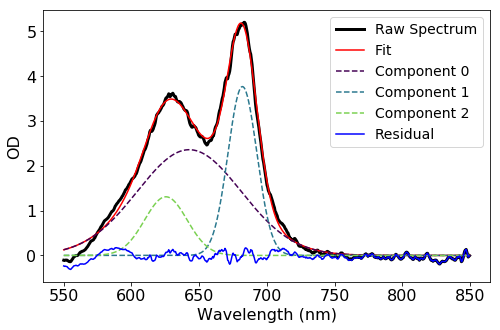

In [87]:
# Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import optimize

plt.rcParams.update({'font.size': 16})

###################################################
# Baseline Correction
###################################################
# Load and plot raw data 
dat = np.loadtxt('SynPCC6803cells.tsv')
laxis = np.arange(550.0, 850.0, 0.5) 
S = np.interp(laxis, dat[:,0], dat[:,1])

# Choose reference points below 700 nm, 
# where real signal is minimal
lambda1 = 750.0
lambda2 = 850.0

# Find the corresponding indices:
n1 = np.argmin(np.abs(laxis-lambda1))
n2 = np.argmin(np.abs(laxis-lambda2))

# Build the baseline:
B = S[n1] + ((S[n2] - S[n1])/(lambda2 - lambda1))*(laxis-lambda1)

# Subtact from the signal
Scorr = S - B


###################################################
# Fitting
###################################################

# Returns a sum of Gaussian profiles with the specified parameters.
# The input argument *params is a pointer to Python list that contains
# 3*N elements. Elements 0, 3, 6, etc. are peak amplitudes; elements
# 1, 4, 7, etc. are peak frequencies; elements 2, 5, 8, etc. are 
# standard deviations. I.e., 
#     params = [amp1, vmax1, sigma1, amp2, vmax2, sigma2,...]
def multi_gauss(xvals, *params):
    
    # yvals will be the total spectrum. Initialize as zeros. 
    yvals = np.zeros(np.shape(xvals))
    
    # Loop over the 3*N parameters, 3 at a time
    for c in range(0, len(params), 3):
        
        # Peak amplitude
        amp = params[c]
        
        # Center frequency
        vmax = params[c+1]
        
        # Standard deviation
        sigma = params[c+2]
        
        # Gaussian Profile
        prof = np.exp(-(xvals-vmax)**2/(2*sigma*sigma))
        
        # If you want a Lorentzian profile instead, uncomment the line below. 
        # In that case, sigma will represent half-width at half-maximum. 
        #prof = (1.0)/((xvals-vmax)**2 + sigma**2)
        
        # Add to total spectrum, scaled by amp
        yvals += amp*prof/np.max(prof)
        
    return yvals


def fit_spec(spec, vaxis, Ncomp):
    
    # This is the peak frequency of the input spectrum
    vpeak = vaxis[np.argmax(spec)]
    
    # This is the half-width of the spectrum
    hwhm = np.abs(vaxis[np.argmin(np.abs(spec-0.5*np.max(spec)))] - vpeak)
    
    # As a crude first guess, we'll space the Ncomp Gaussians equally from
    # vpeak-hwhm to vpeak+hwhm
    vguess = np.linspace(vpeak-hwhm, vpeak+hwhm, Ncomp)
    
    # We'll set the standard deviations to hwhm/Ncomp
    sigmas = np.ones((Ncomp,))*hwhm/Ncomp
    
    # We'll set the amplitudes to evenly distribute
    # the total amplitude of the input spectrum between curves. 
    amps = np.ones((Ncomp,))*np.max(spec)/Ncomp
    
    # Create an empty list to store input parameters
    inpars = [[] for n in range(0, 3*Ncomp)]
    for n in range(0, Ncomp):
        inpars[3*n] = amps[n]
        inpars[3*n+1] = vguess[n]
        inpars[3*n+2] = sigmas[n]
    
    # And now we optimize. We set default bounds to 0 and infinity for all parameters. 
    # (You can also provide a list of bounds for each parameter individually.)
    pars, parcov = optimize.curve_fit(multi_gauss, vaxis, spec, inpars, bounds=(0,np.inf))
    
    return pars


# Call the optimization function:
Ncurves = 3
fpars = fit_spec(Scorr, laxis, Ncurves)
fspec = multi_gauss(laxis, *fpars)

for n in range(0, Ncurves):
    print('Comp ' + str(n) + ':')
    print('    Amp:\t' + str(fpars[3*n]))
    print('    mu:\t\t' + str(fpars[3*n+1]))
    print('    sigma:\t' + str(fpars[3*n+2]))
    print()

###################################################
# Plotting
###################################################

# Define a color map for components
Colors = mpl.cm.viridis(np.linspace(0, 0.8, Ncurves))

plt.figure(figsize=(8,5))
plt.plot(laxis, Scorr, 'k', label='Raw Spectrum',
        linewidth=3)
plt.plot(laxis, fspec, 'r', label='Fit')
for n in range(0, Ncurves):
    plt.plot(laxis, multi_gauss(laxis, *fpars[3*n:3*(n+1)]), '--',
             color=Colors[n], label='Component '+str(n))
plt.plot(laxis, Scorr-fspec, 'b', label='Residual')
plt.legend(fontsize=14)
plt.xlabel('Wavelength (nm)')
plt.ylabel('OD')
plt.show()


# How do I correct for atmospheric water vapor in FTIR spectra? #

A common problem in FTIR spectroscopy is interference from atmospheric water vapor due to humidity in the air. Gaseous water produces very sharp lines that show up as narrow "spikes" in spectroscopic data, particularly around the 1600 cm$^{-1}$ region (the H-O-H bend vibration) and just above 3000 cm$^{-1}$ (the O-H stretch vibration). 

Fortunately, water vapor lines are relatively easy (and safe) to remove since their narrowness makes them easy to distinguish from nearly any condensed-phase signal. Often this is done by hand, by just collecting a spectrum of water vapor and manually scaling to match the amplitude of the sharp features in the original spectrum. Breathing on your beam path is a good way to amplify water-vapor signal when collecting a reference spectrum. (Just be careful not to breath so hard that water condenses on the optics, since this will produce contribute a broad spectrum reflecting a thin film of liquid water.)

The code below gives an example of how this process can be automated by applying a high-frequency filter to the data to select specifically the water noise. The `scipy.optimize` library is used to find the scaling factor that optimally eliminates this high-frequency signal. The experimental spectrum is an FTIR spectrum of aqueous Myoglobin. 

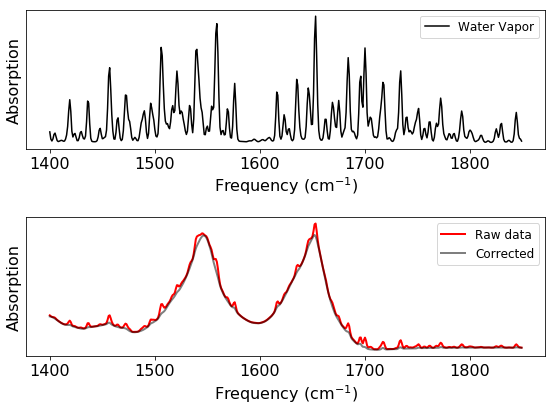

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

plt.rcParams.update({'font.size': 16})

###############################################################
# Automated Atmospheric Correction
###############################################################

# The key distinguishing feature between water vapor lines and
# condensed-phase signals is spectral width: Water lines are 
# narrower than 1 cm$^{-1}$, while condensed-phase vibrations
# are almost always at least 5 cm-1 broad. Thus the optimal 
# atmospheric subtraction is the one that gets rid of signals
# narrower than roughly 5 cm-1. The corrected spectrum will
# have the form
#   
#    Scorr = Spec - fac*VaporSpec
#
# where Spec is the input spectrum, VaporSpec is the spectrum of
# the water vapor, and fac is an undetermined scaling factor 
# that must be optimized. To find the optimal correction, we vary
# fac and at each iteration
#   1. Calculate Scorr
#   2. Take the difference between Scorr and a smoothed spectrum
#      where most of the water noise has been eliminated. 
#   3. Apply a *high-frequency* filter to this difference spectrum
#      to get a "noise" spectrum. 
# The value of fac that mimizes the absolute value of this "noise"
# spectrum gives the optimal correction. 
# 
# The function check_atm() tests a given value of fac and returns
# the noise spectrum. The function fix_atm() uses the scipy.optimize 
# library to search for the optimal value of fac. 
def check_atm(spec, fac):
    
    # Construct a *high-frequency* window, that selects for high-frequency signal.
    # First we construct a Gaussian, just like for smoothing
    sig = 2.5
    gaus = np.exp(-(vaxis-np.mean(vaxis))**2/(2.0*sig**2))
    gaus /= np.sum(gaus)

    # Now Fourier transform it to get a low-frequency filtefrom scipy import optimizer
    lfwin = np.abs(np.fft.fft(gaus))

    # This filter has value 1 at low frequencies, but drops to zero 
    # toward high frequencies. 
    lfwin /= np.max(lfwin)

    # Taking 1 - lfwin produces a filter that is 1 at *high* frequencies 
    # but drops to zero at *low* frequencies. This will select for 
    # high frequency signals like water vapor. 
    hfwin = 1.0 - lfwin

    # This is the difference between the corrected spectrum 
    # (spec - fac*vdat) and the smoothed spectrum. 
    diff = (spec - fac*vdat) - np.convolve(spec, gaus, 'same')
    
    # This is the high-frequency-filtered difference. 
    # We're trying to get this as close as possible to zero. 
    return np.abs(np.fft.ifft(hfwin*np.fft.fft(diff)))


# This function identifies the scaling factor that minimizes
# the residual high-frequency signal after atmospheric correction. 
def fix_atm(spec, vspec, vaxis):
    
    # Set the initially guess to 0.0 (no correction)
    cfac = [0.0]
    
    # And optimize the scaling factor. 
    pars = optimize.curve_fit(check_atm, spec, 0.0*vaxis, *cfac)
    
    # Return the corrected spectrum. pars[0][0] holds the optimized
    # scaling factor. 
    return spec - pars[0][0]*vdat


###############################################################
# Load data
###############################################################

# A convenience function to load data and interpolate to the desired
# frequency axis (vaxis). 
def get_spec(fname, vaxis):
    dat = np.loadtxt(fname, delimiter=',')
    ydat = np.interp(vaxis, dat[:,0], dat[:,1])
    return ydat

v1 = 1400.0
v2 = 1850.0
vstep = 1.0
vaxis = np.arange(v1, v2, vstep)

vdat = get_spec('H2O-vapor.dpt', vaxis)
protdat = get_spec('Mgb.dpt', vaxis)

###############################################################
# Plotting
###############################################################

plt.figure(figsize=(8,6))

# First we'll just plot the water vapor spectrum for reference
plt.subplot(2,1,1)
plt.plot(vaxis, vdat, 'k', label='Water Vapor')
plt.yticks([])
plt.ylabel('Absorption')
plt.xlabel('Frequency (cm$^{-1}$)')
plt.legend(fontsize=12)

plt.subplot(2,1,2)

# Now the raw data
plt.plot(vaxis, protdat, 'r', label='Raw data',
        linewidth=2)

# And the corrected data
plt.plot(vaxis, fix_atm(protdat, vdat, vaxis), 'k', 
         label='Corrected', alpha=0.5,
        linewidth=2)
plt.yticks([])
plt.ylabel('Absorption')
plt.xlabel('Frequency (cm$^{-1}$)')

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# What is "reabsorption"? #

Reabsorption is a common source of artifacts in fluorescence measurements that occurs when the optical density of a sample is too high. Best practice when working with a new sample is always to collect fluorescence spectra at two different concentrations to make sure that reabsorption isn't affecting the line shape. But a good rule of thumb is that if the OD is greater than 1, reabsorption is likely to be a problem. Physically, reabsorption refers to a three-step process where 
1. one molecule absorbs light, 
2. that same molecule (or another molecule connected by rapid energy transfer) gives off the excitation energy as fluorescence, and 
3. a third molecule absorbs the newly fluoresced light, so that it either never reaches the detector or (due to either the Stokes shift or energy transfer) gets re-fluoresced further to the red of the original fluorescent signal. 

Because fluorescence always occurs to the red of the original absorption peak, reabsorption induces a red-shift in affected fluorescence signals. 

The plot below shows an example of reabsorption in two different samples of an antenna-free strain of *Synechocystis PCC 6803*. The fluorescent features near 680 and 695 nm (red filled area, due to Photosystem II) which are visible in the low-OD sample are absent in the high-OD sample -- despite the fact that the only difference between the two samples is that one is diluted by a factor of $\sim$4. 

Why the difference? Reabsorption: because the 680 - 695 nm features overlap strongly with the main absorption peak near 680 nm, any fluorescence in this region is immediately reabsorbed and systematically down-shifted until the excitation energy either decays nonradiatively or it makes its way into one of the Photosystem I red states near 720 nm whose fluorescence is less susceptible to reabsorption.

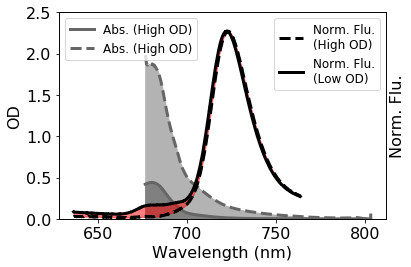

In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

# Intensity of light passing through the low-OD sample
IntLow = np.loadtxt('SPBSm_LowOD.txt')

# Intensity of light passing through the high-OD sample
IntHigh = np.loadtxt('SPBSm_HighOD.txt')

# Intensity of light passing through without sample. 
# (This is collected just before the low-OD transmission)
bkgLow = np.loadtxt('bkg_LowOD.txt')

# Intensity of light passing through without sample. 
# (This is collected just before the high-OD transmission)
bkgHigh = np.loadtxt('bkg_HighOD.txt')

# This is the raw optical density of the low-OD sample. 
odLow = -np.log10(IntLow[:,1]/bkgLow[:,1])

# We subtract off the value at 800 nm since
# scatter typically produces an offset for these samples. 
# If published, this would be acknowledged as "Raw absorption
# spectra were corrected with an overall offset to give
# an OD of 0.0 at 800 nm."
odLow -= odLow[np.argmin(np.abs(800.0 - IntLow[:,0]))]

# Same for High-OD sample. 
odHigh = -np.log10(IntHigh[:,1]/bkgHigh[:,1])
odHigh -= odHigh[np.argmin(np.abs(800.0 - IntHigh[:,0]))]

# Fluorescence from the low-OD sample
flLow = np.loadtxt('SPBSm_good_fluorescence.txt')

# Fluorescence from the low-OD sample
flHigh = np.loadtxt('SPBSm_reabsorption.txt')

# Normalized Fluorescence:
yLow = flLow[:,1]/np.max(flLow[:,1])
yHigh = flHigh[:,1]/np.max(flHigh[:,1])


# First we plot absorption
plt.figure()
plt.plot(IntLow[:,0], odLow, '-', color=np.ones((3,))*0.4,
         linewidth=3, label='Abs. (High OD)')

plt.plot(IntHigh[:,0], odHigh, '--', color=np.ones((3,))*0.4,
         linewidth=3, label='Abs. (High OD)')

# Highlight absorption background with filled curves
plt.fill_between(IntHigh[:,0], odHigh, color=np.ones((3,))*0.7)
plt.fill_between(IntLow[:,0], odLow, color=np.ones((3,))*0.5)

plt.legend(fontsize=12, loc='upper left')
plt.ylabel('OD')
plt.xlabel('Wavelength (nm)')
# plt.xlim(660, 780)
plt.ylim(0, 2.5)

# Now we plot fluorescence on a separate axis. 
# plt.gca().twinx() creates a new axis object that 
# can have independent y-scaling and labels. 
ax2 = plt.gca().twinx()
plt.plot(flLow[:,0], yHigh, 
         'k--', linewidth=3, label='Norm. Flu.\n(High OD)')
plt.plot(flLow[:,0], yLow, 
         'k', linewidth=3, label='Norm. Flu.\n(Low OD)')
plt.fill_between(flLow[:,0], yLow, yHigh,
                color='r', alpha=0.5)

plt.ylim(0, 1.1)
plt.yticks([])
plt.ylabel('Norm. Flu.')
plt.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()

# How do you recognize artifacts in an experimental UV/Vis or IR spectrum? #

Recognizing artifacts is as much an art as a science; there's no fool-proof strategy to ensure that your data is "correct". This takes practice and a bit of intuition. But here are a few helpful questions to ask yourself before you believe your own data: 

### 1. Is it reproducible? ###

This is probably the single best test for the validity of a spectroscopic feature. Of course a reproducible signal can still be an artifact; but a signal that isn't reproducible is almost certainly an artifact. (Or it indicates a lack of reproducibility in your sample preparation, which is equally problematic.)

At its most basic level, the reproducibility test just consists in making the same measurement several times under identical conditions. But the test is much stronger if you also vary experimental parameters that you know should **not** affect the signal. For example, if you prepare the sample on two different days, with two different sets of stock solutions, and make the measurement on two different instruments, do the signals still look identical? 

For specific measurements, more creative tests can be devised. In IR spectroscopy, isotope replacement is often useful. The spectra below show experimental FTIR spectra of DSMO straight from the bottle (black) and after adding a trace amount of deuterated water (D$_2$O) in green. Note that the intensity of the peak near 1650 cm$^{-1}$ (right inset) decreases substantially upon D$_2$O addition. This peak thus cannot be an intrinsic vibration of DMSO since DMSO has no exchangeable protons, and therefore its vibrations should be unaffected by the presence of trace D$_2$O. Conversely, a peak appears near 1200 cm$^{-1}$, along with a small shoulder near 1475 cm$^{-1}$. 

What's going on here is that the original peak near 1650 cm$^{-1}$ was an H-O-H bend vibration due to trace water in the solvent. Addition of D$_2$O splits this band between the original 1650 cm$^{-1}$ region and two new peaks reflecting the D-O-D bend (near 1200 cm$^{-1}$) and the H-O-D bend vibration near 1475 cm$^{-1}$. 

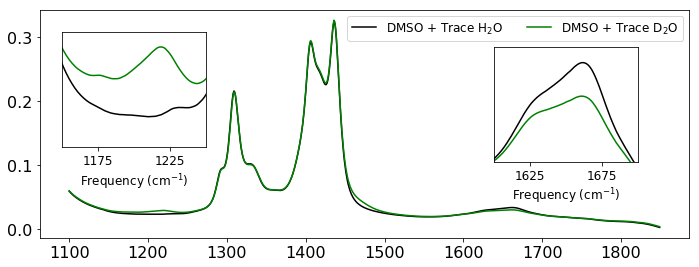

In [151]:
import numpy as np
import matplotlib.pyplot as plt

def get_spec(fname, vaxis):
    dat = np.loadtxt(fname, delimiter=',')
    ydat = np.interp(vaxis, dat[:,0], dat[:,1])
    return ydat

v1 = 1100.0
v2 = 1850.0
vstep = 1.0
vaxis = np.arange(v1, v2, vstep)

dmso_h = get_spec('DMSO.dpt', vaxis)
dmso_d = get_spec('DMSO-D2O.dpt', vaxis)

plt.figure(figsize=(10,4))
plt.plot(vaxis, dmso_h, 'k', label='DMSO + Trace H$_2$O')
plt.plot(vaxis, dmso_d, 'g', label='DMSO + Trace D$_2$O')
plt.legend(ncol=2, fontsize=12)
plt.tight_layout()

# Inset for 1200 cm-1 feature:
plt.axes((0.1, 0.45, 0.2, 0.4))
plt.plot(vaxis, dmso_h, 'k')
plt.plot(vaxis, dmso_d, 'g')
plt.yticks([])
plt.xlim(1150, 1250)
plt.xticks([1175, 1225], fontsize=12)
plt.xlabel('Frequency (cm$^{-1}$)', fontsize=12)
plt.ylim(0.02, 0.03)

# Inset for 1650 cm-1 feature:
plt.axes((0.7, 0.4, 0.2, 0.4))
plt.plot(vaxis, dmso_h, 'k')
plt.plot(vaxis, dmso_d, 'g')
plt.yticks([])
plt.xlim(1600, 1700)
plt.xticks([1625, 1675], fontsize=12)
plt.xlabel('Frequency (cm$^{-1}$)', fontsize=12)
plt.ylim(0.0225, 0.035)

plt.show()

### 2. Is it larger than the noise? ###

This is perhaps obvious, but you'd be surprised how often it gets overlooked: if your signal is comparable to the background noise, it's impossible to make confident assignments!

The difficulty here is often to know what exactly is your "noise floor", i.e., the level of signal beyond which you can confidently assign a feature as "signal". Confidence is often quantified by the "signal-to-noise" (or S/N) ratio, i.e., the ratio of the maximum amplitude of your (suspected) signal to the maximum amplitude of the noise. If your S/N is 1:1, you're probably looking at noise. If it's 10:1, you can be pretty confident that it isn't. (Although it could still be another type of artifact, such as a contaminant in your sample!)

The best way to assess your S/N is usually to find a region of your spectrum (as close as possible to the signal of interest) where you **know** you won't have any real signal. In vibrational spectroscopy, a convenient window is often the range from 1800 cm$^{-1}$ to around 2400 cm$^{-1}$ since very few chemical moieties absorb in this range. In electronic spectroscopy, wavelengths longer than 800 nm are often (though not always) a good place to use as a reference since very few organic molecules absorb in this region. (Although semiconductors often do!) 

### 3. Is it similar to any known contaminants? ###

What constitutes a "known contaminant" of course depends strongly on your specific application, so it's often a good idea to collect "control" spectra for the different compounds that go into your sample or could be reasonably anticipated to be formed during sample preparation. 

A common example in peptide/protein IR spectroscopy is trifluoroacetic acid (TFA), a common additive during reverse-phase chromatography peptide purification that gives rise to a very strong peak near 1670 cm$^{-1}$. Another example common in our lab is the strong absorption band from imidazole (used during Ni-NTA affinity chromatography) that shows up near cm$^{-1}$. Without prior knowledge of these absorption bands, it's easy to mistake such signals for real protein absorption. 

### 4. Is it within the working dynamic range of your instrument? ###

The "dynamic range" of a system/detector is the range of signal amplitudes that can be accurately recorded without either
1. saturating the detector or
2. falling below the noise floor. 

**"Saturating the detector"** means that the signal amplitude is so large that the detector no longer reflects changes in amplitude. All detectors have such a saturation point; for example, if your detector translates input light intensity into an electrical current or voltage difference, the underlying electronics will at some point reach a maximum value where no higher current can be supported. At this point the detector is "saturated" since increased light intensity can no longer trigger any change to the output voltage. The plot below shows an example from a fluorescence measurement using a liquid N$_2$-cooled CCD camera. 


**"Falling below the noise floor"** means that signal can no longer be meaningfully distinguished from background noise. But note that this can show up in unexpected ways. In an absorption measurement, the reported signal is of the form
$$ A = - \log_{10} \frac{I}{I_0}$$
where $I$ is the intensity of a light beam that passes through the sample, and $I_0$ is the intensity of the same light beam when the sample is absent or when a reference (background) sample is substituted in its place. If it should happen that the reference sample absorbs strongly in some particular frequency range, the light reaching the detector is effectively 0 in this region for *both* $I$ and $I_0$, leading to floating point instability when the ratio $I/I_0$ is calculated by the computer. Depending on how the instrument is set up to handle this, this may show up as noise, as a flat line at some (often unpredictable) level, or some combination of the two.  

As an example, consider the three UV spectra below for a solution containing protein at 0.79 mg/mL, 4 mg/mL, and 12 mg/mL. Interpreted literally, the data suggest that the 235 nm peak in the 12 mg/mL sample shifts to 225 nm in the 4 mg/mL sample and off the screen to below 200 nm in the 0.79 mg/mL sample. But note the actual values of the ODs: In all cases, the OD in the vicinity of this peak is at least 5, which means that only $1\cdot 10^{-5}$ of the light impinging on the sample is actually reaching the detector. With such small amounts of light reaching it, the detector is unlikely to be able to distinguish accurately between, say, $1\cdot 10^{-5}$ (corresponding to OD=5 for the 0.79 mg/mL sample) and $1\cdot 10^{-20}$ (corresponding to OD=20 for the 12 mg/mL sample). The readings in this region are simply not reliable. 

Whenever possible, it's a good rule of thumb to work with samples that have ODs less than 1. (Closer to 0.1 is preferable.) This avoids a range of problems, including the dynamic range issues just discussed as well as effects like reabsorption in fluorescence measurements and lineshape distortion in 2D spectra. 

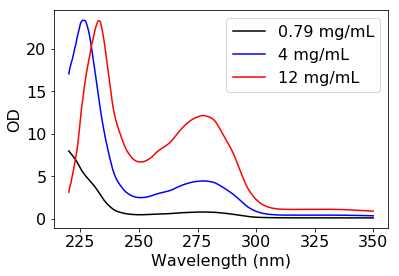

In [192]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

slow = np.loadtxt('0o79mgml.csv', delimiter=',')
smid = np.loadtxt('4mgml.csv', delimiter=',')
shigh = np.loadtxt('12mgml.csv', delimiter=',')

plt.plot(slow[:,0], slow[:,1], 'k', label='0.79 mg/mL')
plt.plot(smid[:,0], smid[:,1], 'b', label='4 mg/mL')
plt.plot(shigh[:,0], shigh[:,1], 'r', label='12 mg/mL')

plt.xlabel('Wavelength (nm)')
plt.ylabel('OD')
plt.legend()
plt.show()


### 5. Is it unreasonably broad or unreasonably narrow? ###

This last test of course takes some practice and intuition, but "unreasonably" broad or narrow signals are often a red flag that something is amiss. The two most common examples in our lab are extremely broad baslines produced by scattered light and very sharp lines produced by gaseous water vapor. (See above discussion of baseline and water-vapor corrections.)